## Crime forecasting with NeuralProphet - using weather and covid data as additional regressors

1. Importing libraries

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
import random   
import numpy as np
from neuralprophet import utils
random.seed(42)
np.random.seed(42)
utils.set_random_seed(seed=42)

2. Importing daily crime count with weather and covid data.

<Axes: xlabel='ds'>

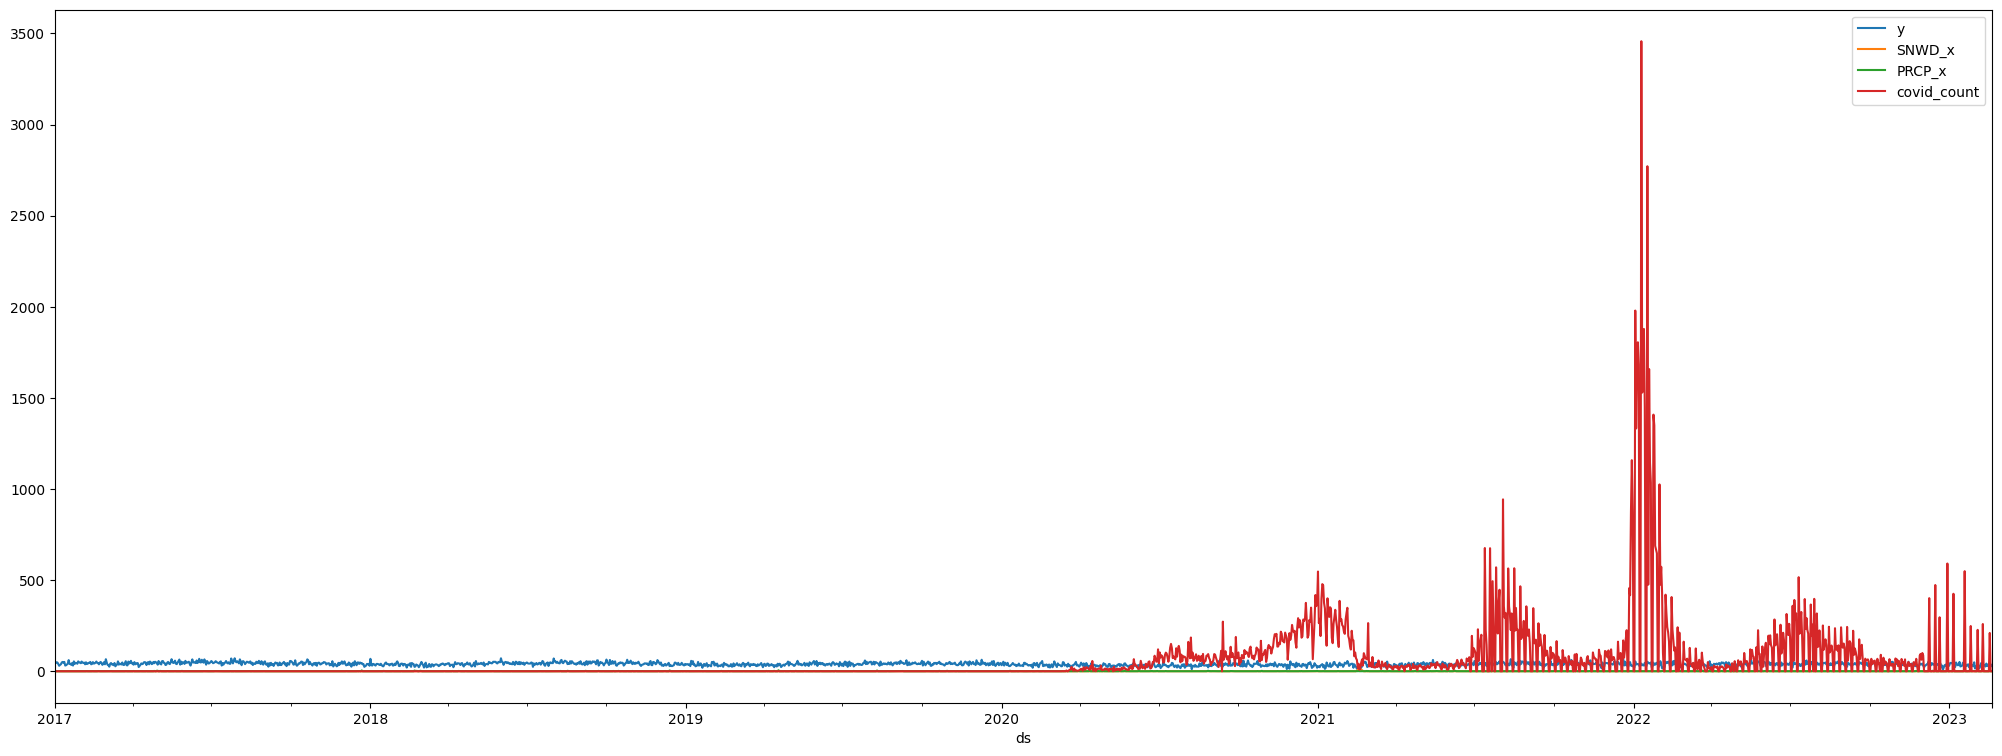

In [2]:
df2 = pd.read_csv("../../../data/daily-count-w-weather-covid.csv")
df2 = df2[["ds", "y", "SNWD_x", "PRCP_x", "covid_count"]]
df2["ds"] = pd.to_datetime(df2["ds"])
df2.set_index('ds').plot(figsize=(25, 9))

In [3]:
train = df2[:int(0.8 * (len(df2)))]
test = df2[int(0.8 * (len(df2))):]
train.tail(), test.head()

(             ds   y  SNWD_x  PRCP_x  covid_count
 1788 2021-11-24  33     0.0    0.00         85.0
 1789 2021-11-25  16     0.0    0.17         28.0
 1790 2021-11-26  48     0.0    0.00         23.0
 1791 2021-11-27  35     0.0    0.00          0.0
 1792 2021-11-28  25     0.0    0.00          0.0,
              ds   y  SNWD_x  PRCP_x  covid_count
 1793 2021-11-29  47     0.0     0.0        111.0
 1794 2021-11-30  45     0.0     0.0        108.0
 1795 2021-12-01  45     0.0     0.0         85.0
 1796 2021-12-02  43     0.0     0.0         76.0
 1797 2021-12-03  45     0.0     0.0        114.0)

3. Fitting the NeuralProphet with default settings and weather + daily COVID data as additional regressors.

In [4]:
#Disable verbose for neuralprophet
import sys
import logging
log = logging.getLogger("")
logging.disable(sys.maxsize)

m = NeuralProphet()

m = m.add_country_holidays(country_name='US')
m = m.add_future_regressor("SNWD_x")
m = m.add_future_regressor("PRCP_x")
m = m.add_future_regressor("covid_count")

m.fit(train)
future = m.make_future_dataframe(train, periods=test.shape[0], regressors_df=test[["SNWD_x", "PRCP_x", "covid_count"]])
forecast = m.predict(future)
forecast_on_train = m.predict(train)


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

In [5]:
forecast_on_train.head()

,ds,y,yhat1,trend,season_yearly,season_weekly,events_additive,event_Christmas Day,event_Christmas Day (Observed),event_Columbus Day,...,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday,future_regressors_additive,future_regressor_PRCP_x,future_regressor_SNWD_x,future_regressor_covid_count
0,2017-01-01,54,39.854744,45.209091,-1.962326,-5.146363,1.769985,0.0,0.0,0.0,...,1.769985,0.000000,0.0,0.0,0.0,0.0,-0.015646,-0.015646,0.0,0.0
1,2017-01-02,45,45.164951,45.225605,-2.031462,3.151019,-0.867295,0.0,0.0,0.0,...,0.000000,-0.867295,0.0,0.0,0.0,0.0,-0.312915,-0.312915,0.0,0.0
2,2017-01-03,49,43.767433,45.242115,-2.096534,0.621854,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,2017-01-04,48,43.445244,45.258625,-2.157049,0.343668,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,2017-01-05,39,43.915600,45.275139,-2.212542,0.853002,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


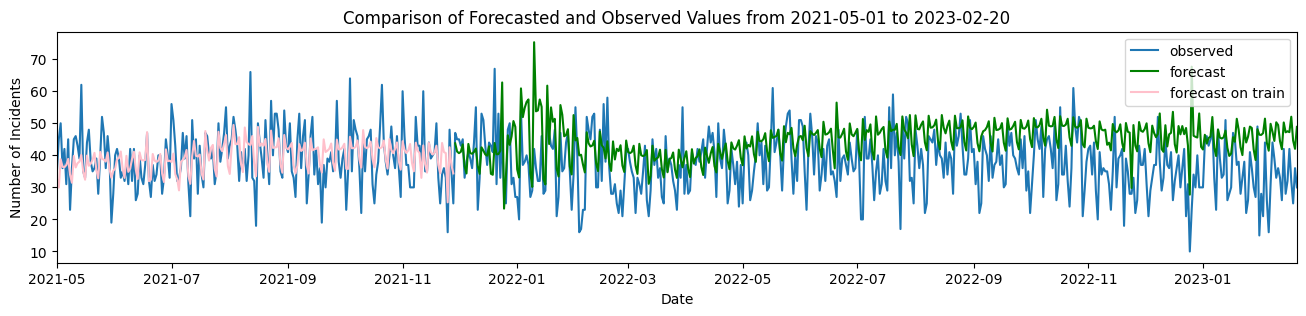

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
plt.plot(df2.ds, df2.y, label='observed')

plt.plot(forecast['ds'], forecast['yhat1'],
         label='forecast', color='green')
plt.plot(forecast_on_train['ds'], forecast_on_train['yhat1'],
         label='forecast on train', color='pink')
plt.title('Comparison of Forecasted and Observed Values from 2021-05-01 to ' + str(test.ds.iloc[-1])[:10])
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()

plt.xlim(pd.Timestamp('2021-05-01'), pd.Timestamp(test.ds.iloc[-1]))
plt.gcf().set_size_inches(16, 3)
plt.savefig('../neural-prophet-forecast.png')
plt.show()

In [7]:
test = test.merge(forecast[['ds', 'yhat1']], how='left', on='ds')

4. Outputting final metrics for the model.

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print('R2: ', r2_score(y_pred=forecast.yhat1, y_true=df2.y[-len(forecast.yhat1):]))
rmse = mean_squared_error(y_pred=forecast.yhat1, y_true=df2.y[-len(forecast.yhat1):], squared=False)
print('RMSE: ', rmse)



R2:  -0.6351110874589223
RMSE:  11.613957468386364


### Provided worse metrics than without COVID data probably due to inaccuracies in daily infection count.